In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import medfilt
import pywt
from ecgdetectors import Detectors

scd_data = {'./data/scddb/30': '07:54:33',
 './data/scddb/31': '13:42:24',
 './data/scddb/32': '16:45:18',
 './data/scddb/33': '04:46:19',
 './data/scddb/34': '06:35:44',
 './data/scddb/35': '24:34:56',
 './data/scddb/36': '18:59:01',
 './data/scddb/37': '01:31:13',
 './data/scddb/38': '08:01:54',
 './data/scddb/39': '04:37:51',
 './data/scddb/41': '02:59:24',
 './data/scddb/43': '15:37:11',
 './data/scddb/44': '19:38:45',
 './data/scddb/45': '18:09:17',
 './data/scddb/46': '03:41:47',
 './data/scddb/47': '06:13:01',
 './data/scddb/48': '02:29:40',
 './data/scddb/50': '11:45:43',
 './data/scddb/51': '22:58:23',
 './data/scddb/52': '02:32:40'}


fs = 250

In [3]:
def hms_to_seconds(hms):
    h, m, s = hms.split(':')
    return int(h)*3600 + int(m)*60 + int(s)

def extract_before_onset_VF(vfon_dict, minutes_before=30):
    ecg_data_map = {} 

    for record_path, vf_onset_str in vfon_dict.items():
        # record_path might be '.data/scddb/30'
        record_dir, record_name = os.path.split(record_path)

        # 2) Convert dictionary's VF onset to seconds
        vf_onset_original_sec = hms_to_seconds(vf_onset_str)

        vfon_onset_original_sample = vf_onset_original_sec * fs

        seg_len_samples = int(minutes_before * 60 * fs)

        start_sample = vfon_onset_original_sample - seg_len_samples

         # read .dat between those sample indices
        try:
            #record_dat_path = os.path.join(record_dir, record_name)  # base path
            record_path_dat = os.path.join(record_dir, record_name)
            segment = wfdb.rdrecord(record_path_dat, sampfrom=start_sample, sampto=vfon_onset_original_sample)
            
        except Exception as e:
            print(f"[ERROR] Failed to read record {record_dat_path}: {e}")
            continue

        # Retrieve the raw signal data as a NumPy array
        if segment.p_signal is not None:
            arr = segment.p_signal[:,0]
            ecg_data_map[record_name] = arr
            print(f"[OK] Extracted 30-min for {record_name}: shape={arr.shape}")
        else:
            print(f"[WARNING] No p_signal found for {record_name}")

    return ecg_data_map

def segment_ecg(ecg_segment, segment_duration_sec=300, fs=250):
    samples_per_segment = segment_duration_sec * fs
    segments = np.array_split(ecg_segment, len(ecg_segment) // samples_per_segment)
    return segments

In [4]:
onsetVF_30min_scd = extract_before_onset_VF(scd_data, minutes_before=30)
onset30_6segments_5mins = segment_ecg(onsetVF_30min_scd['30'])
first_5min_of30 = onset30_6segments_5mins[5]

[OK] Extracted 30-min for 30: shape=(450000,)
[OK] Extracted 30-min for 31: shape=(450000,)
[OK] Extracted 30-min for 32: shape=(450000,)
[OK] Extracted 30-min for 33: shape=(450000,)
[OK] Extracted 30-min for 34: shape=(450000,)
[OK] Extracted 30-min for 35: shape=(450000,)
[OK] Extracted 30-min for 36: shape=(450000,)
[OK] Extracted 30-min for 37: shape=(450000,)
[OK] Extracted 30-min for 38: shape=(450000,)
[OK] Extracted 30-min for 39: shape=(450000,)
[OK] Extracted 30-min for 41: shape=(450000,)
[OK] Extracted 30-min for 43: shape=(450000,)
[OK] Extracted 30-min for 44: shape=(450000,)
[OK] Extracted 30-min for 45: shape=(450000,)
[OK] Extracted 30-min for 46: shape=(450000,)
[OK] Extracted 30-min for 47: shape=(450000,)
[OK] Extracted 30-min for 48: shape=(450000,)
[OK] Extracted 30-min for 50: shape=(450000,)
[OK] Extracted 30-min for 51: shape=(450000,)
[OK] Extracted 30-min for 52: shape=(450000,)


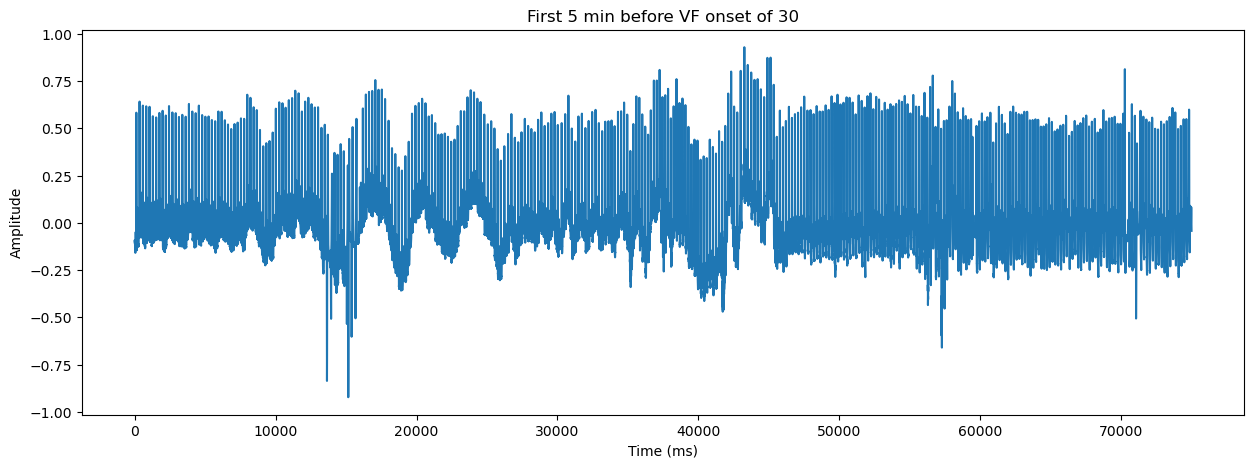

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot()
plt.plot(first_5min_of30)
plt.title('First 5 min before VF onset of 30')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.show()

# Denoise

In [6]:
def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = pywt.wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y